##### Methods

We post-process the snapshots of TIGRESS simulations with the adaptive ray tracing method in Athena. The TIGRESS is a novel framework for vertically stratified shearing box simulations of galactic disks including realistic supernovae feedback, cooling, magnetic fields, and gas and stellar gravity.

For each snapshot, we read in gas density, (temperature), sink particle data, and simulation time as inputs. We refer to star particles younger than 40 Myr as young star clusters (YSCs, "feedback" particles in Kim & Ostriker (2017)), which are treated as point radiation sources. For a sink particle of given mass $M_∗$ and mass-weighted age $t_{\rm age}$, we determine the FUV (non-ionizing) luminoisty $L_{\rm FUV} = \Psi_{\rm FUV}(t_{\rm age})M_*$ and EUV (Lyman continuum) luminosity $L_{\rm EUV} \equiv Q_{\rm i}\langle h\nu_{\rm i}\rangle = \Xi_{\rm EUV}(t_{\rm age})M_*$, where $Q_{\rm i}$ is the ionizing photon rate and $\langle h\nu_{\rm i}\rangle = 18\,{\rm eV}$ is the mean energy of hydrogen-ionizing photons. The opacity per unit length at EUV is

\begin{equation}
\chi_{\rm EUV} = \sigma_{\rm d} n_{\rm H} + \sigma_{\rm pi} n_{\rm H^0}
\end{equation}

For simplicity, we take constant values $\sigma_{\rm d} = \kappa_{\rm d}\mu_{\rm H} \approx 1.17 \times 10^{-21}\,{\rm cm}^{-2}\,{\rm H}^{-1}$ for the dust absorption cross section per H and $\sigma_{\rm pi} = 3.0 \times 10^{-18}\,{\rm cm}^{2}\,{\rm H}^{-1}$ for photionization cross section per H. For FUV opacity, we adopt $\sigma_{\rm d} = \kappa_{\rm d}\mu_{\rm H} \approx 1.17 \times 10^{-21}\,{\rm cm}^{-2}\,{\rm H}^{-1}(=500\,{\rm cm}^2\,{\rm g}^{-1}\mu_{\rm H})$.


We use the angular resolution parameter $m_{\rm ray} = 4$ for adaptive ray tracing so that each grid cell is sampled by at least four rays per source. Similar to other flow attributes, we implement the shear-periodic boundary conditions for rays crossing the radial boundaries. For example, if a ray exits the far radial boundary at $y = y_0$, it re-enters the near radial boundary at $y = y_0 + {\rm sgn}(L_y−\Delta y−y_0) \times (L_y−\Delta y)$ where $\Delta y=(q\Omega L_x t \;{\rm mod}\; L_y)$ with the position of the source offset accordingly. The azimuthal ($y$) boundary condition is strictly periodic. We follow a ray until one of the following conditions is satisfied: (1) the ray needs to split; (2) the optical depth from the source is larger than $\tau_{\rm max} = 7$; (3) the ray exits the computational domain in the $z$-direction; (4) the distance from the source is larger than $d_{\rm max}$.


Description of ionizing radiative transfer. (1) Raytracing to get photoionization rate (2) update neutral fraction. Iterate (1) and (2) until the volume of the ionized gas converges.

##### Source codes

* __prob/radps_postproc_tig.c__: problem generator for postprocessing


* __radps/radps.c__: driver routines for ART and source term updates.


* __radps/raytracing.c__: routines for PhotonPacket (PP) transport and cell-PP interaction

##### Constants and parameters

* dmaxPP \[pc\] ($d_{\rm max}$): maximum distance photon packets can travel from source.
    - For photon packets traveling horizontally with $\mu \equiv \mathbf{\hat{n}}_{\rm ray} \cdot \mathbf{\hat{z}} \approx 0$, we want dmaxPP to be at least $L_x$ or $\sqrt{2}L_x$.
    - Since we are interested in how far photons from star clusters propagate in the vertical direction, we want dmaxPP to be at least $L_{z}$, but this is now computationally feasible for tall-box simulations. We have to resort to plane-parallel approximation at high-altitues.

* active_age \[Myr\]: star particles with (mass-weighted) mean age < active_age are considered as source.

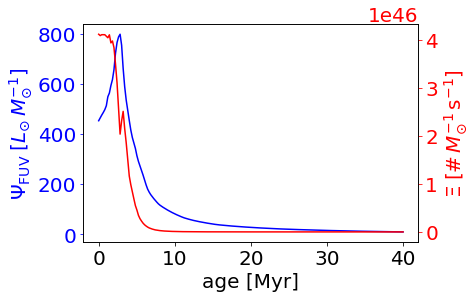

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'../')
import calc_lum

age = np.linspace(0, 40.0, 200)
plt.rc('font', size=20)
with plt.rc_context({'ytick.color':'b', 'axes.labelcolor':'b'}):
    plt.plot(age, calc_lum.calc_LFUV(1.0, age), 'b-')
    plt.xlabel('age [Myr]', color='k')
    plt.ylabel(r'$\Psi_{\rm FUV}\;[L_{\odot}\,M_{\odot}^{-1}]$')
    #plt.yscale('log')

with plt.rc_context({'ytick.color':'r', 'axes.labelcolor':'r'}):
    axt = plt.gca().twinx()
    axt.plot(age, calc_lum.calc_Qi(1.0, age), 'r-')
    plt.ylabel(r'$\Xi\;[{\rm \#}\,M_{\odot}^{-1}\,{\rm s}^{-1}]$')
    #plt.yscale('log')


##### radps_postproc_tig workflow

* problem
    - set code units, parse input parameters
    - read 3d vtk and starpar vtk data
        - density, ..., pressure computed from MHD simulations

        * The H-neutral fraction is set to the equilibrium value __in the absence of ionizing radiation__

\begin{equation}
x_{\rm n,eq} = \frac{\alpha_{\rm B}}{\gamma_{\rm coll} + \alpha_{\rm B}}
\end{equation}

where Case-B recombination coefficient is

\begin{equation}
\alpha_{\rm B} \approx 2.59\times 10^{-13}\,{\rm cm}^{3}\,{\rm s}^{-1}
\end{equation}

and collisional ionization rate coefficient

\begin{equation}
\gamma_{\rm coll} \approx 5.84\times 10^{-11} \times \sqrt{T/K} \exp(-13.6\,{\rm eV}/(k_{\rm B}T))
\end{equation}

([Krumholz et al. 2007](https://arxiv.org/abs/astro-ph/0606539)).

__Equilibrium neutral fraction as a function of T__

Text(0,0.5,'$x_{\\rm n,eq}$')

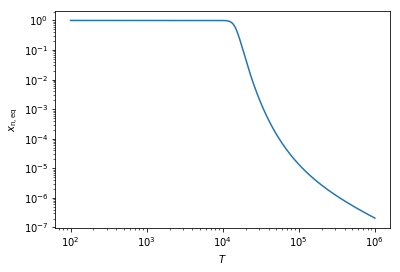

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as au
import astropy.constants as ac

hnu_over_kB = (13.6*au.eV/ac.k_B).cgs.value
kcoll = lambda T: 5.84e-11*T**0.5*np.exp(-hnu_over_kB/T)
alphaB = lambda T: 2.59e-13*(T/1e4)**-0.7

T = np.logspace(2, 6, 300)
xneq = alphaB(T)/(kcoll(T) + alphaB(T))
plt.loglog(T, xneq)
plt.xlabel(r'$T$')
plt.ylabel(r'$x_{\rm n,eq}$')

* Hot gas ($T \gtrsim 2\times 10^4 K$) is collisionally ionized even without ionizing radiation.

##### References

* Altay & Theuns 2013: https://arxiv.org/abs/1304.4235
    * See their Appendix C3 for time-dependent solution of the H-neutral fraction